In [2]:
# from vis import barplot, recompute
from vis import get_palette, recompute
import seaborn as sns 
import json 
import pathlib 
import pandas as pd 
import re 
import subprocess
from matplotlib import pyplot as plt 
import numpy as np 

In [75]:
from metrics import accuracy_report

def barplot(csv_groups, 
            level, 
            x_name, 
            hue_name, 
            title=None, 
            ax=None, 
            filtered = False, 
            ignore_first_only = False, 
            ignore_list=None,
            offset = 0.015,
            other_offset = None):
    # consolidate data from different csvs 
    all_dfs = {g:[] for g in csv_groups.keys()}
    for group, csvs in csv_groups.items():
        for csv in csvs:
            try:
                df = pd.read_csv(csv)
                # print(csv, len(df))
                all_dfs[group].append(df)
            except FileNotFoundError:
                print(f"Not found: {csv}")


    reports = {g: [accuracy_report(df, ignore_first_only, total_only=True) for df in dfs] for g, dfs in all_dfs.items()}
    # data = [report[level] for report in reports]
    data = {g: [report[level] for report in group_reports] for g, group_reports in reports.items()}
    df_to_plot = pd.DataFrame(columns=["model", "acc", "type"], dtype=object)
    for group, group_data in data.items():
        for i, data_dict in enumerate(group_data):
            df = all_dfs[group][i]
            model_name = df['model'][0]
            model_name = re.sub("_", "-", model_name)
            model_name = re.sub("-qa", "", model_name)
            if type(data_dict) == dict:
                for k, v in data_dict.items():
                    if filtered: 
                        acc = float(v[2])
                    else:
                        acc = float(v[0])
                    type_name = k
                    df_to_plot = df_to_plot.append({"model": model_name, "acc": acc, "type": type_name, "group": group}, ignore_index=True)
            else:
                # v, __, __, __ = data_dict
                v= data_dict
                if filtered: 
                    acc = float(v[2])
                else:
                    acc = float(v[0])
                type_name = "total"
                df_to_plot = df_to_plot.append({"model": model_name, "acc": acc*100, "type": type_name, "group": group}, ignore_index=True)
    palette = get_palette()

    order = [ "gpt-neo-1.3b", "gpt-neo-2.7b", "gpt-j", "gpt3", "jurassic-large","jurassic-jumbo","t5", "t0"]
    if ignore_list is not None:
        for gex in ignore_list:
            order = [x for x in order if re.match(gex, x) is None]

    g = sns.catplot(data = df_to_plot, 
                    kind='bar', 
                    x = x_name,
                     y = 'acc', 
                     hue = hue_name, 
                     palette=palette, 
                     col="group", 
                     hue_order=order,
                     legend=False)
    g.set(ylim=(0, 105))

    for ax_idx in range(3): 
        ax = g.facet_axis(0,ax_idx)
        for p in ax.patches:
            if p.get_height() > 99.5:
                if other_offset is None:
                    offset_to_use = -0.001
                else:
                    offset_to_use = other_offset
            else:
                offset_to_use = offset
            ax.text(p.get_x() + offset_to_use, 
                p.get_height(), 
                '{0:.0f}'.format(p.get_height()),   #Used to format it K representation
                color='black', 
                rotation='horizontal',
                font='sans',
                fontsize='11')

    if title is not None:
        g.fig.subplots_adjust(top=0.9) 
        g.fig.suptitle(title) 
    for ax_line in g.axes:
        for ax in ax_line:
            xs = (-0.4, 0.4)
            ys = (0.5, 0.5)
            ax.plot(xs, ys, "-", color="#000000")
    g.set_titles("{col_name}", size=14) 
    # g.set_titles("{col_name}") 
    g.set_xticklabels([])
    g.set_xticklabels([])
    g.set(xlabel=None)
    g.set(xticks=[])
    return g 


In [78]:
def compute_max_over_instructions(instruction_dirs, results_dir, best_instruction_dir="best_instructions", idx=2, restrict=None, recompute=True): 
    df = pd.DataFrame(columns=["model", "instruction_dir", "results_dir", "type", "value"], dtype=object)
    for instruction_dir in instruction_dirs:
        if recompute:
            oc_acc, poc_acc, sc_acc = recompute_all(instruction_dir, results_dir)
        else:
            oc_acc, poc_acc, sc_acc = get_accs_logits(instruction_dir, results_dir)
        models = set(oc_acc.keys()) & set(poc_acc.keys()) & set(sc_acc.keys())
        print(f"models {models}")
        if restrict is not None:
            models = [x for x in models if x in restrict]
        for model in models:
            df = df.append({"model": model, "instruction_dir": instruction_dir, "results_dir": results_dir, "type": "oc", "value": oc_acc[model][idx] }, ignore_index=True)
            df = df.append({"model": model, "instruction_dir": instruction_dir, "results_dir": results_dir, "type": "poc", "value": poc_acc[model][idx] }, ignore_index=True)
            df = df.append({"model": model, "instruction_dir": instruction_dir, "results_dir": results_dir, "type": "sc", "value": sc_acc[model][idx] }, ignore_index=True)
    max_df = pd.DataFrame(columns=["model", "instruction_dir", "results_dir", "type", "value"], dtype=object)
    done = []
    # instruction_dirs = ["with_instructions", "short_instructions"]
    for i, row in df.iterrows():
        other_instruction_dir = [x for x in instruction_dirs if x != row['instruction_dir']][0]
        value1 = row['value']
        other_row = df[(df['model'] == row['model']) & (df['instruction_dir'] == other_instruction_dir) & 
                    (df['results_dir'] == row['results_dir']) & (df['type'] == row['type'])]
        try:
            value2 = other_row['value'].values[0]
        except IndexError:
            pass
        if value1 > value2:
            max_df = max_df.append(row, ignore_index=True)
        else:
            max_df = max_df.append(other_row, ignore_index=True)
    # best_instruction_dir = "best_instructions"
    for i, row in max_df.iterrows():
        results_dir = row['results_dir']
        if row['type'] == "oc":
            exp_type = "object_control"
        elif row['type'] == "poc":
            exp_type = "passive_object_control"
        else:
            exp_type = "subject_control" 
        model = re.sub("-", "_", row['model'])
        model = re.sub("_qa", "", model)
        model = re.sub("_large", "", model)
        instruction_dir = row['instruction_dir']
        src_path = f"../{instruction_dir}/{results_dir}/{model}_{exp_type}.csv"
        out_path = f"../{best_instruction_dir}/{results_dir}/{model}_{exp_type}.csv"
        subprocess.Popen(["cp", src_path, out_path])
    return df, max_df

def recompute_all(instruction_dir, results_dir, nickname_file="nicknames.json"):
    pathlib.Path(f"../{instruction_dir}/{results_dir}_to_plot").mkdir(exist_ok=True)
    names = ["gpt", "gpt-neo-1.3b", "gpt-neo-2.7b", "gpt-j", "jurassic-large", "jurassic-jumbo", "t5_qa", "t0"]
    nicknames = json.load(open(f"../data/{nickname_file}"))
    pre_oc_csvs = [
     f"../{instruction_dir}/{results_dir}/gpt_object_control.csv", 
     f"../{instruction_dir}/{results_dir}/gpt_neo_1.3b_object_control.csv", 
     f"../{instruction_dir}/{results_dir}/gpt_neo_2.7b_object_control.csv", 
     f"../{instruction_dir}/{results_dir}/gpt_j_object_control.csv", 
     f"../{instruction_dir}/{results_dir}/jurassic_object_control.csv",
     f"../{instruction_dir}/{results_dir}/jurassic_jumbo_object_control.csv", 
     f"../{instruction_dir}/{results_dir}/t5_object_control.csv",
     f"../{instruction_dir}/{results_dir}/t0_object_control.csv"]

    print(f"recompute object control")
    oc_acc = recompute(pre_oc_csvs, names, nicknames, exp_name = "object-control", results_path=f"{instruction_dir}/{results_dir}_to_plot")   

    pre_poc_csvs = [
     f"../{instruction_dir}/{results_dir}/gpt_passive_object_control.csv", 
     f"../{instruction_dir}/{results_dir}/gpt_neo_1.3b_passive_object_control.csv", 
     f"../{instruction_dir}/{results_dir}/gpt_neo_2.7b_passive_object_control.csv", 
     f"../{instruction_dir}/{results_dir}/gpt_j_passive_object_control.csv", 
     f"../{instruction_dir}/{results_dir}/jurassic_passive_object_control.csv",
     f"../{instruction_dir}/{results_dir}/jurassic_jumbo_passive_object_control.csv", 
     f"../{instruction_dir}/{results_dir}/t5_passive_object_control.csv",
     f"../{instruction_dir}/{results_dir}/t0_passive_object_control.csv"]
    
    print(f"recompute passive object control")
    poc_acc = recompute(pre_poc_csvs, names, nicknames, exp_name = "object-control-passive", results_path=f"{instruction_dir}/{results_dir}_to_plot")   

    pre_sc_csvs =  [
     f"../{instruction_dir}/{results_dir}/gpt_subject_control.csv", 
     f"../{instruction_dir}/{results_dir}/gpt_neo_1.3b_subject_control.csv", 
     f"../{instruction_dir}/{results_dir}/gpt_neo_2.7b_subject_control.csv", 
     f"../{instruction_dir}/{results_dir}/gpt_j_subject_control.csv", 
     f"../{instruction_dir}/{results_dir}/jurassic_subject_control.csv",
     f"../{instruction_dir}/{results_dir}/jurassic_jumbo_subject_control.csv", 
     f"../{instruction_dir}/{results_dir}/t5_subject_control.csv",
     f"../{instruction_dir}/{results_dir}/t0_subject_control.csv"]

    print(f"recompute subject control")
    sc_acc = recompute(pre_sc_csvs, names, nicknames, exp_name = "subject-control", results_path=f"{instruction_dir}/{results_dir}_to_plot") 
    return oc_acc, poc_acc, sc_acc

def get_accs_logits(instruction_dir, results_dir):
    oc_acc, poc_acc, sc_acc = {}, {}, {}

    for model in ["gpt_neo_1.3b", "gpt_neo_2.7b", "gpt_j", "t5", "t0"]: 
        for setting in ["object_control", "passive_object_control", "subject_control"]: 
            csv_path = f"../{instruction_dir}/{results_dir}/{model}_{setting}.csv"
            df = pd.read_csv(csv_path)
            results = df.to_dict(orient="records")
            res_binary = [1 if x['pred'] == x['true'] else 0 for x in results]
            acc = np.sum(res_binary)/len(res_binary)
            if setting == "object_control":
                oc_acc[model] = (0,0,acc,0)
            elif setting == "passive_object_control":
                poc_acc[model] = (0,0,acc,0)
            elif setting == "subject_control":
                sc_acc[model] = (0,0,acc,0)
            else:
                raise AssertionError
                
    return oc_acc, poc_acc, sc_acc

def plot_all(instruction_dir, 
             results_dir, 
             recompute=True, 
             filtered=True, 
             ignore_first_only = False, 
             nickname_file="nicknames.json", 
             title=None, 
             ncol=4,
             offset=0.015,
             other_offset=None,
             ignore_list=None):

    if recompute:
        print(f"recomputing...")
        recompute_all(instruction_dir, results_dir, nickname_file=nickname_file)

    oc_csvs=[
        f"../{instruction_dir}/{results_dir}_to_plot/gpt_object_control.csv", 
        f"../{instruction_dir}/{results_dir}_to_plot/gpt_neo_1.3b_object_control.csv", 
        f"../{instruction_dir}/{results_dir}_to_plot/gpt_neo_2.7b_object_control.csv", 
        f"../{instruction_dir}/{results_dir}_to_plot/gpt_j_object_control.csv", 
        f"../{instruction_dir}/{results_dir}_to_plot/jurassic_object_control.csv", 
        f"../{instruction_dir}/{results_dir}_to_plot/jurassic_jumbo_object_control.csv", 
        f"../{instruction_dir}/{results_dir}_to_plot/t5_object_control.csv",
        f"../{instruction_dir}/{results_dir}_to_plot/t0_object_control.csv"]

    sc_csvs=[
        f"../{instruction_dir}/{results_dir}_to_plot/gpt_subject_control.csv", 
        f"../{instruction_dir}/{results_dir}_to_plot/gpt_neo_1.3b_subject_control.csv",
        f"../{instruction_dir}/{results_dir}_to_plot/gpt_neo_2.7b_subject_control.csv", 
        f"../{instruction_dir}/{results_dir}_to_plot/gpt_j_subject_control.csv",
        f"../{instruction_dir}/{results_dir}_to_plot/jurassic_subject_control.csv", 
        f"../{instruction_dir}/{results_dir}_to_plot/jurassic_jumbo_subject_control.csv", 
        f"../{instruction_dir}/{results_dir}_to_plot/t5_subject_control.csv",
        f"../{instruction_dir}/{results_dir}_to_plot/t0_subject_control.csv"]

    poc_csvs=[
        f"../{instruction_dir}/{results_dir}_to_plot/gpt_passive_object_control.csv", 
        f"../{instruction_dir}/{results_dir}_to_plot/gpt_neo_1.3b_passive_object_control.csv",
        f"../{instruction_dir}/{results_dir}_to_plot/gpt_neo_2.7b_passive_object_control.csv",
        f"../{instruction_dir}/{results_dir}_to_plot/gpt_j_passive_object_control.csv",
        f"../{instruction_dir}/{results_dir}_to_plot/jurassic_passive_object_control.csv", 
        f"../{instruction_dir}/{results_dir}_to_plot/jurassic_jumbo_passive_object_control.csv", 
        f"../{instruction_dir}/{results_dir}_to_plot/t5_passive_object_control.csv",
        f"../{instruction_dir}/{results_dir}_to_plot/t0_passive_object_control.csv"]

    if ignore_list is not None:
        for name in ignore_list:
            gex = re.compile(name)

            oc_csvs = [x for x in oc_csvs if gex.match(x) is None]
            poc_csvs = [x for x in poc_csvs if gex.match(x) is None]
            sc_csvs = [x for x in sc_csvs if gex.match(x) is None]

    csv_data = {"Object control": oc_csvs, "Passive object control": poc_csvs, "Subject control": sc_csvs}
    print("plotting...")
    g = barplot(csv_data, level="total", x_name = "type", hue_name = "model", 
                filtered=filtered, ignore_first_only=ignore_first_only, 
                title=title, ignore_list=ignore_list, offset=offset, other_offset=other_offset)
                
    g.figure.set_size_inches(8.5, 3.0)
    g.set(ylabel=None)
    for ax in g.axes.flat:
        ax.set_xticklabels([])
        box = ax.get_position()
        ax.set_position([box.x0,box.y0,box.width,box.height*0.92])
        
    plt.legend(loc='lower center', ncol=ncol, frameon=False, bbox_to_anchor= (-0.6, -0.30), fontsize=12)
    plt.show()

    sns.despine()
    return g

In [ ]:
df, max_df = compute_max_over_instructions(["with_instructions", "short_instructions"], "results")
print(max_df)

In [ ]:
df, max_df = compute_max_over_instructions(["with_instructions", "short_instructions"], "results_hacked")
print(max_df)

In [ ]:
sns.set_theme(context='paper', style='white', font_scale=1.3, font='serif')
g = plot_all("with_instructions", "results", recompute=False, title="Zero-shot, Long instructions")
g.savefig("/home/estengel/papers/control-probe/figures/just_long.pdf")
# plot_all("short_instructions", "results", recompute=False, title="Zero-shot, Short instructions")
sns.set_theme(context='paper', style='white', font_scale=1.3, font='serif')


g=plot_all("best_instructions", "results", recompute=False, title="Zero-shot, Best prompt")
plt.tight_layout()
g.savefig("/home/estengel/papers/control-probe/figures/zero_shot_best.pdf")

In [ ]:

# plot_all("with_instructions", "results_hacked", recompute=False)
# plot_all("short_instructions", "results_hacked", recompute=False)
sns.set_theme(context='paper', style='white', font_scale=1.3, font='serif')

g=plot_all("best_instructions", "results_hacked", recompute=False, title="Prompt-hacked, Best prompt", ignore_list=[".*t5.*"])
g.savefig("/home/estengel/papers/control-probe/figures/hacked_best.pdf")

In [ ]:
plot_all("with_instructions", "results_just_prompt_agent", recompute=True)
plot_all("short_instructions", "results_just_prompt_agent", recompute=True)

In [ ]:
plot_all("with_instructions", "results_just_prompt_patient", recompute=True)
plot_all("short_instructions", "results_just_prompt_patient", recompute=True)

In [ ]:
sns.set_theme(context='paper', style='white', font_scale=1.3, font='serif')
g = plot_all("with_instructions", "results_profession", recompute=False, nickname_file="nicknames_professions.json")
g.savefig("/home/estengel/papers/control-probe/figures/profession.pdf")

In [ ]:
plot_all("short_log_probs", "results", recompute=False, ignore_list = [".*gpt3.*", ".*gpt[\-_][osp].*", ".*jurassic.*"])
plot_all("long_log_probs", "results", recompute=False, ignore_list = [".*gpt3.*", ".*gpt[\-_][osp].*", ".*jurassic.*"])

In [ ]:
df, max_df = compute_max_over_instructions(["short_log_probs", "long_log_probs"], "results", 
                                    best_instruction_dir = "best_log_probs", recompute=False)
                                    # ,
                                    #  restrict=['gpt3', "jurassic", "jurassic_large"])


In [ ]:
# df, max_df = compute_max_over_instructions(["with_instructions", "short_instructions"], "results_extended")
# print(max_df)


plot_all("short_instructions", "results_threaten", recompute=False)
plot_all("short_instructions", "results", recompute=False)

In [ ]:
# df, max_df = compute_max_over_instructions(["with_instructions", "short_instructions"], "results_extended")
# print(max_df)


plot_all("short_instructions", "results_offer", recompute=False)
plot_all("short_instructions", "results_threaten", recompute=False)
plot_all("short_instructions", "results", recompute=False)

In [ ]:
# df, max_df = compute_max_over_instructions(["with_instructions", "short_instructions"], "results_extended")
# print(max_df)


plot_all("with_instructions", "results_offer", recompute=False)
plot_all("with_instructions", "results_threaten", recompute=False)
plot_all("with_instructions", "results", recompute=False)

In [ ]:
df, max_df = compute_max_over_instructions(["with_instructions", "short_instructions"], "results_extended_combined", recompute=True)
# df, max_df = compute_max_over_instructions(["with_instructions", "short_instructions"], "results_threaten")

plotting...


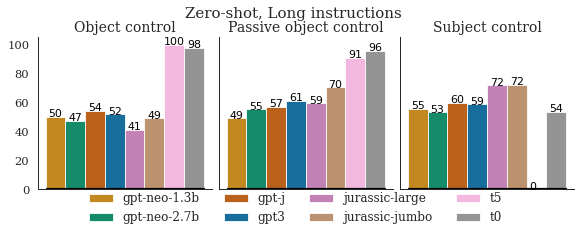

plotting...


<Figure size 432x288 with 0 Axes>

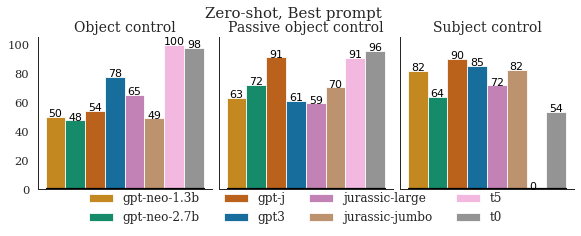

<Figure size 432x288 with 0 Axes>

In [71]:
# df, max_df = compute_max_over_instructions(["with_instructions", "short_instructions"], "results_extended")
# print(max_df)


# g = plot_all("best_instructions", "results_extended_combined", recompute=True, title="Zero-shot, Best prompt")
# plot_all("with_instructions", "results_threaten", recompute=False)
# plot_all("best_instructions", "results", recompute=False)

sns.set_theme(context='paper', style='white', font_scale=1.3, font='serif')
g = plot_all("with_instructions", "results_extended_combined", recompute=False, title="Zero-shot, Long instructions")
g.savefig("/home/estengel/papers/control-probe/figures/just_long_threaten.pdf")
# plot_all("short_instructions", "results", recompute=False, title="Zero-shot, Short instructions")
sns.set_theme(context='paper', style='white', font_scale=1.3, font='serif')


g=plot_all("best_instructions", "results_extended_combined", recompute=False, title="Zero-shot, Best prompt")
plt.tight_layout()
g.savefig("/home/estengel/papers/control-probe/figures/zero_shot_best_threaten.pdf")

In [ ]:
df, max_df = compute_max_over_instructions(["with_instructions", "short_instructions"], "results_extended_hacked_combined", recompute=True)
# df, max_df = compute_max_over_instructions(["with_instructions", "short_instructions"], "results_threaten")

plotting...


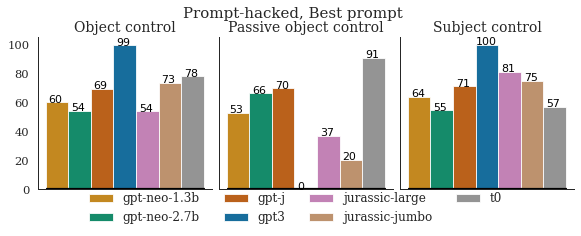

<Figure size 432x288 with 0 Axes>

In [73]:

sns.set_theme(context='paper', style='white', font_scale=1.3, font='serif')

# g=plot_all("best_instructions", "results_hacked", recompute=False, title="Prompt-hacked, Best prompt", ignore_list=[".*t5.*"])
g=plot_all("best_instructions", "results_extended_hacked_combined", title="Prompt-hacked, Best prompt", recompute=False, ignore_list=[".*t5.*"])
g.savefig("/home/estengel/papers/control-probe/figures/hacked_best_threaten.pdf")

recomputing...
recompute object control
recompute passive object control
recompute subject control
plotting...


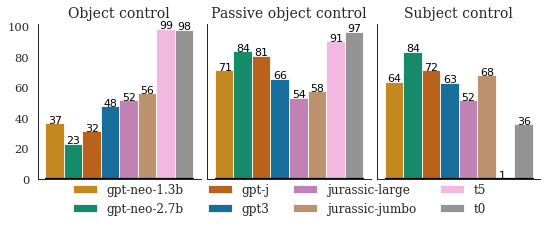

<Figure size 432x288 with 0 Axes>

In [34]:


sns.set_theme(context='paper', style='white', font_scale=1.3, font='serif')
g = plot_all("short_instructions", "results_profession_combined", recompute=False, nickname_file="nicknames_professions.json")
g.savefig("/home/estengel/papers/control-probe/figures/profession_threaten.pdf")

models {'t5', 't0', 'gpt_neo_1.3b', 'gpt_neo_2.7b', 'gpt_j'}
models {'t5', 't0', 'gpt_neo_1.3b', 'gpt_neo_2.7b', 'gpt_j'}
plotting...


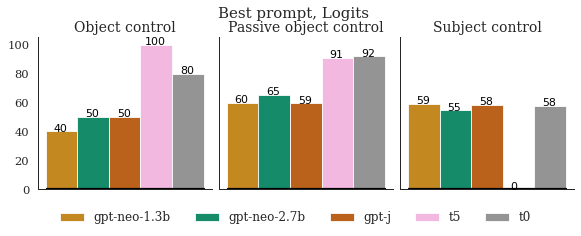

<Figure size 432x288 with 0 Axes>

In [80]:
df, max_df = compute_max_over_instructions(["short_log_probs", "long_log_probs"], "results_combined_to_plot", 
                                    best_instruction_dir = "best_log_probs", recompute=False)
                                    # ,
                                    #  restrict=['gpt3', "jurassic", "jurassic_large"])


g = plot_all("best_log_probs", "results_combined", ncol=5, offset=0.040, other_offset=0.020, title="Best prompt, Logits", recompute=False, ignore_list = [".*gpt3.*", ".*gpt[\-_][osp].*", ".*jurassic.*"])
g.savefig("/home/estengel/papers/control-probe/figures/logits_threaten.pdf")